### Experiment Settings

In [1]:
epochs = 20
max_len = 300

In [2]:
# Experiment_name
experiment_name = 'basline_entire_dataset'

# Naming: model
model_path = '/content/drive/My Drive/CBB-750/Final Project/model/' + experiment_name + '.pt'
print(model_path)

# Naming: training history
training_df_path = '/content/drive/My Drive/CBB-750/Final Project/history/' + experiment_name + '.csv'
print(training_df_path)

/content/drive/My Drive/CBB-750/Final Project/model/basline_entire_dataset.pt
/content/drive/My Drive/CBB-750/Final Project/history/basline_entire_dataset.csv


### GPU

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

from typing import Tuple, List

import random
import math
import os
import time
import json
import numpy as np
from collections import Counter

# We'll set the random seeds for deterministic results.
#SEED = 1

#random.seed(SEED)
#torch.manual_seed(SEED)
#torch.backends.cudnn.enabled = False
#torch.backends.cudnn.deterministic = True



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", DEVICE)

Pytorch version is:  2.0.0+cu118
You are using:  cuda


In [4]:
# mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Dataset

In [5]:
# load the file into a dataframe
import pandas as pd

IG_P = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Info Giving - Patient')
IG_C = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Info Giving - Clinician')
IG_A = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Info Giving - Auto')

IS_C = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Info Seek - Clinician')
IS_P = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Info Seek - Patient')

Emo_P = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Emotion - Patient')
Emo_C = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Emotion - Clinician')

P_C = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Partnership - Clinician')
P_P = pd.read_excel('/content/drive/My Drive/CBB-750/Final Project/Dataset.xlsx', sheet_name='Partnership - Patient')

In [6]:
# Combine IG_P, IG_C, IG_A into one dataframe
IG = pd.concat([IG_P, IG_C, IG_A], axis=0, ignore_index=True)
IG
# Combine IS_C, IS_P into one dataframe
IS = pd.concat([IS_C, IS_P], axis=0, ignore_index=True)

# Combine Emo_P, Emo_C into one dataframe
Emo = pd.concat([Emo_P, Emo_C], axis=0, ignore_index=True)

# Combine P_C, P_P into one dataframe
P = pd.concat([P_C, P_P], axis=0, ignore_index=True)

In [7]:
# Add labels to each dataframe
IG['Label'] = 'Info Giving'
IS['Label'] = 'Info Seeking'
Emo['Label'] = 'Emotion'
P['Label'] = 'Partnership'

# Combine all dataframes into one dataframe
df = pd.concat([IG, IS, Emo, P], axis=0, ignore_index=True)

In [8]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: Tesla V100-SXM2-16GB


In [9]:
possible_labels = df.Label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Info Giving': 0, 'Info Seeking': 1, 'Emotion': 2, 'Partnership': 3}

In [10]:
df['label'] = df.Label.replace(label_dict)
df['text'] = df['Quotation Content']

<Axes: xlabel='Label', ylabel='Count'>

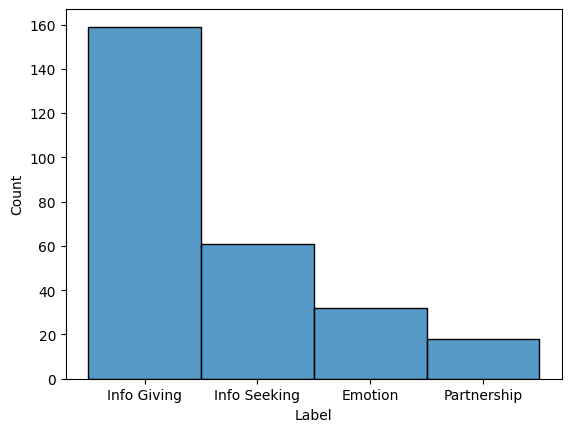

In [11]:
import seaborn as sns
sns.histplot(df['Label'])

### Data Split

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_rem = train_test_split(df,
                                    test_size=0.3,
                                    random_state=1,
                                    stratify=df['label'])

df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=1,
                                    stratify=df_rem['label'])


Shape: (189, 6)
Shape: (40, 6)
Shape: (41, 6)


<Axes: xlabel='Label', ylabel='Count'>

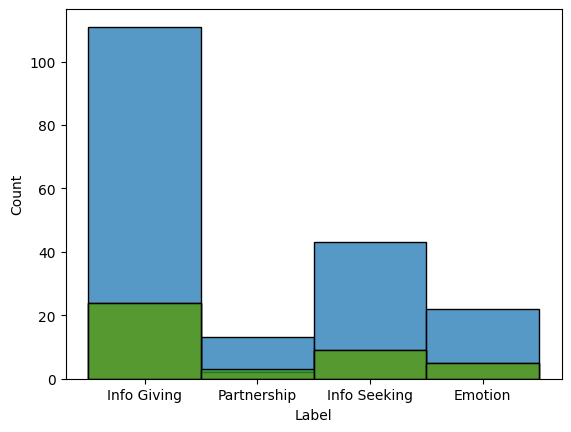

In [13]:
for item in df_train, df_val, df_test:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution 
sns.histplot(df_train['Label'])   
sns.histplot(df_val['Label'])
sns.histplot(df_test['Label'])

### Tokenization

In [14]:
!pip install transformers --quiet

In [15]:
import transformers
from transformers import BertTokenizer

# Load BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          do_lower_case=True)

In [16]:
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['Quotation Content']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        max_length=max_len,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [17]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

In [18]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['label'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [19]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)
test_dataloader = get_dataloader(df_test)


### Import BERT

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertForPreTraining

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

### Training

In [23]:
# Import materics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [24]:
import numpy as np
# Reset history lists
training_stats = []

for epoch_i in range(epochs):
    
    # timer_start
    epoch_t0 = time.time()
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    
    
    # timer_end
    epoch_time_spent = time.time() - epoch_t0
    print('  Time spent on the epoch: {:.2f}'.format(epoch_time_spent))
    print('\n')
    
    # Recording training stats
    training_stats.append(
        {
            'Epoch': epoch_i+1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_acc': acc,
            'time_spent': epoch_time_spent
        })

【EPOCH: 1/ 20】
Trainig Phase
  Average training loss: 1.5694
Validation Phase
  Average validation loss: 1.3337
  Validation accruacy: 0.3250
  Time spent on the epoch: 3.71


【EPOCH: 2/ 20】
Trainig Phase
  Average training loss: 1.2470
Validation Phase
  Average validation loss: 1.2382
  Validation accruacy: 0.5750
  Time spent on the epoch: 3.11


【EPOCH: 3/ 20】
Trainig Phase
  Average training loss: 1.1231
Validation Phase
  Average validation loss: 1.0140
  Validation accruacy: 0.6000
  Time spent on the epoch: 3.07


【EPOCH: 4/ 20】
Trainig Phase
  Average training loss: 1.0888
Validation Phase
  Average validation loss: 1.0286
  Validation accruacy: 0.6000
  Time spent on the epoch: 3.06


【EPOCH: 5/ 20】
Trainig Phase
  Average training loss: 1.0344
Validation Phase
  Average validation loss: 1.0773
  Validation accruacy: 0.6000
  Time spent on the epoch: 3.05


【EPOCH: 6/ 20】
Trainig Phase
  Average training loss: 0.9891
Validation Phase
  Average validation loss: 1.0047
  Valida

### Training performance

In [25]:
train_loss = []
val_loss = []
val_acc = []
time_spent = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    val_loss.append(training_stats[i]['val_loss'])
    val_acc.append(training_stats[i]['val_acc'])
    time_spent.append(training_stats[i]['time_spent'])

Time spent on training 20 epochs: 1 minutes


Text(0.5, 1.0, 'accuracy')

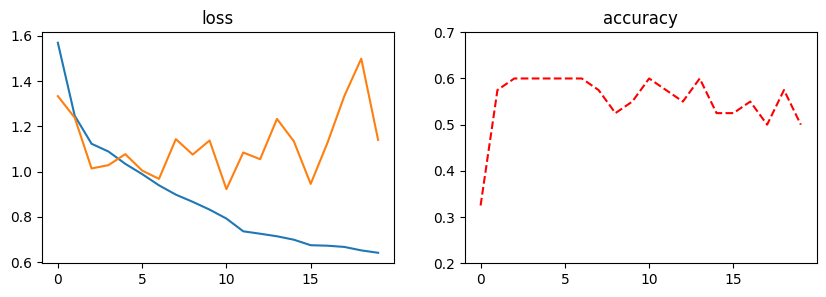

In [46]:
# Print time spent
print('Time spent on training {} epochs: {:.0f}'.format(epochs, np.sum(time_spent)/60) + ' minutes')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(val_acc, color='red', linestyle='--')
plt.ylim(0.2, 0.7)
plt.title('accuracy')

In [27]:
torch.save(model.state_dict(), model_path)

### Perform on the test data

In [28]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

Number of batches in the dataloader: 2


In [29]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)

In [30]:
# Set up list of test labels
ls_test_labels = df_test['Label'].values
rev_subs = { v:k for k,v in label_dict.items()}
ls_test_pred = [rev_subs.get(item,item)  for item in ls_test_pred]
# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.5366


In [31]:
label_dict.keys()

dict_keys(['Info Giving', 'Info Seeking', 'Emotion', 'Partnership'])

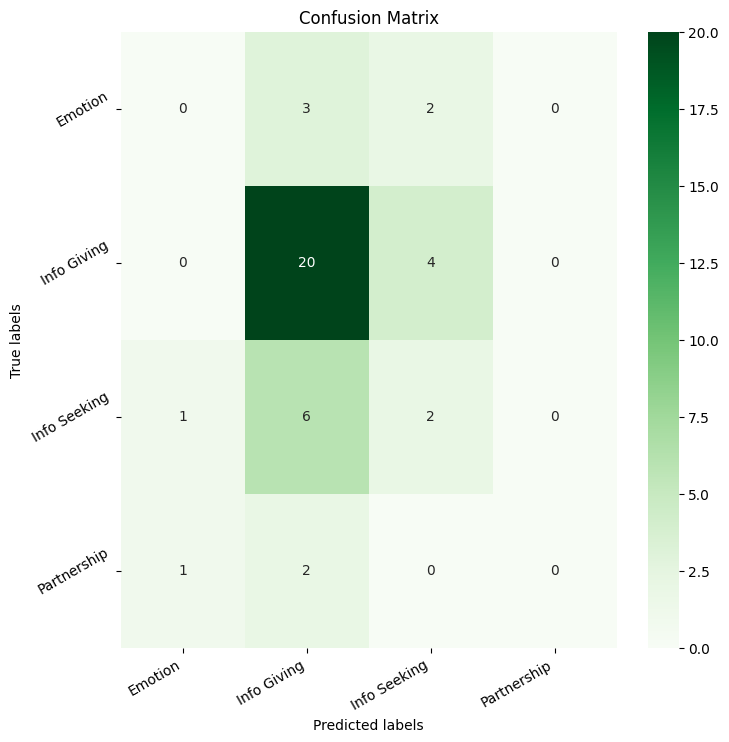

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         5
 Info Giving       0.65      0.83      0.73        24
Info Seeking       0.25      0.22      0.24         9
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.54        41
   macro avg       0.22      0.26      0.24        41
weighted avg       0.43      0.54      0.48        41



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Confusion matrix
cm = confusion_matrix(ls_test_labels, ls_test_pred)
labels = ["Emotion","Info Giving","Info Seeking","Partnership"]

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(list(ls_test_labels),list(ls_test_pred),labels=list(labels)))

### ClinicalBERT

In [33]:
!pip install pytorch-pretrained-bert

from transformers import AutoTokenizer, AutoModel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.9 MB/s eta 0:00:00


In [34]:

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.tr

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Tokenization

In [35]:
!pip install transformers --quiet

In [36]:
import transformers
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [37]:
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['Quotation Content']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        max_length=max_len,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [38]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

In [39]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['label'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [40]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)
test_dataloader = get_dataloader(df_test)


### Import BERT

In [41]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [42]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

### Training

In [44]:
# Import materics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [45]:
import numpy as np
# Reset history lists
training_stats = []

for epoch_i in range(epochs):
    
    # timer_start
    epoch_t0 = time.time()
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    
    
    # timer_end
    epoch_time_spent = time.time() - epoch_t0
    print('  Time spent on the epoch: {:.2f}'.format(epoch_time_spent))
    print('\n')
    
    # Recording training stats
    training_stats.append(
        {
            'Epoch': epoch_i+1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_acc': acc,
            'time_spent': epoch_time_spent
        })

【EPOCH: 1/ 20】
Trainig Phase


AttributeError: ignored

### Training performance

In [ ]:
train_loss = []
val_loss = []
val_acc = []
time_spent = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    val_loss.append(training_stats[i]['val_loss'])
    val_acc.append(training_stats[i]['val_acc'])
    time_spent.append(training_stats[i]['time_spent'])

In [ ]:
# Print time spent
print('Time spent on training {} epochs: {:.0f}'.format(epochs, np.sum(time_spent)/60) + ' minutes')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(val_acc, color='red', linestyle='--')
plt.title('accuracy')

In [ ]:
torch.save(model.state_dict(), model_path)

### Perform on the test data

In [ ]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

In [ ]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)

In [ ]:
# Set up list of test labels
ls_test_labels = df_test['Label'].values
rev_subs = { v:k for k,v in label_dict.items()}
ls_test_pred = [rev_subs.get(item,item)  for item in ls_test_pred]
# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

In [ ]:
label_dict.keys()

In [ ]:
# Confusion matrix
cm = confusion_matrix(ls_test_labels, ls_test_pred)
labels = label_dict.keys()

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(list(ls_test_labels),list(ls_test_pred),labels=list(labels)))

### Clinical Bert




### Experiment Settings

In [ ]:
epochs = 20
max_len = 300

In [ ]:
# Experiment_name
experiment_name = 'basline_entire_dataset'

# Naming: model
model_path = '/content/drive/My Drive/CBB-750/Final Project/model/' + experiment_name + '.pt'
print(model_path)

# Naming: training history
training_df_path = '/content/drive/My Drive/CBB-750/Final Project/history/' + experiment_name + '.csv'
print(training_df_path)

/content/drive/My Drive/CBB-750/Final Project/model/basline_entire_dataset.pt
/content/drive/My Drive/CBB-750/Final Project/history/basline_entire_dataset.csv


### GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

from typing import Tuple, List

import random
import math
import os
import time
import json
import numpy as np
from collections import Counter

# We'll set the random seeds for deterministic results.
#SEED = 1

#random.seed(SEED)
#torch.manual_seed(SEED)
#torch.backends.cudnn.enabled = False
#torch.backends.cudnn.deterministic = True



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", DEVICE)

Pytorch version is:  2.0.0+cu118
You are using:  cuda


In [ ]:
# mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/CBB-750/Final Project/augmented_data.csv')
df_gpt = pd.read_csv('/content/drive/My Drive/CBB-750/Final Project/GPTMessageLabelCode.csv')
df_gpt['Quotation Content'] = df_gpt['Message']
df = pd.concat([df, df_gpt], ignore_index=True)
# Combine all dataframes into one dataframe

In [ ]:
df_combined

NameError: ignored

In [ ]:
#df = df[df['Label']!="SDM"]
#df_1 = df[df['Label']=="Info Giving"]
#from random import randint
#x = [randint(0, 158) for p in range(0, 98)]
#df = df.drop(x)

In [ ]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: NVIDIA A100-SXM4-40GB


In [ ]:
possible_labels = df.Label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Info Giving': 0, 'Info Seeking': 1, 'Emotion': 2, 'Partnership': 3, 'SDM': 4}

In [ ]:
df['label'] = df.Label.replace(label_dict)
df['text'] = df['Quotation Content']

<Axes: xlabel='Label', ylabel='Count'>

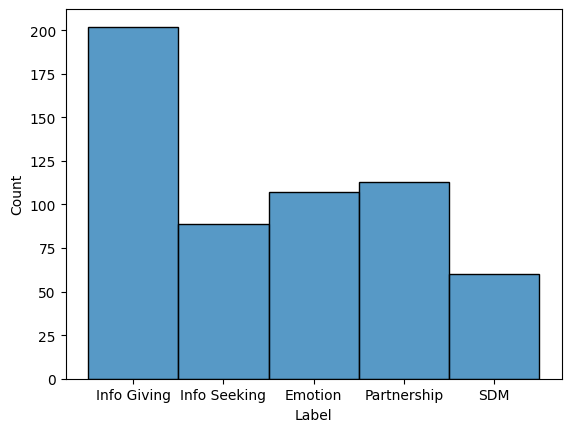

In [ ]:
import seaborn as sns
sns.histplot(df['Label'])

### Data Split

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_rem = train_test_split(df,
                                    test_size=0.3,
                                    random_state=1,
                                    stratify=df['label'])

df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=1,
                                    stratify=df_rem['label'])


Shape: (399, 7)
Shape: (86, 7)
Shape: (86, 7)


<Axes: xlabel='Label', ylabel='Count'>

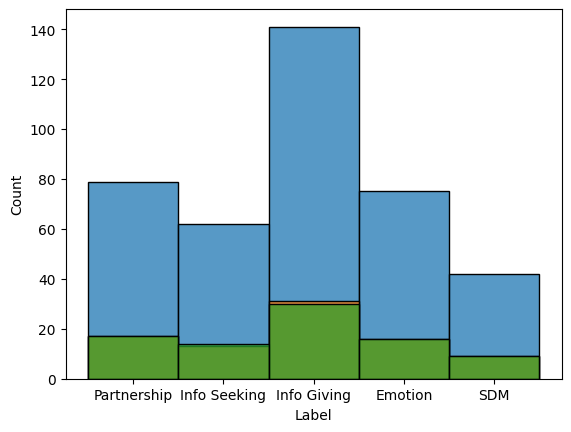

In [ ]:
for item in df_train, df_val, df_test:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution 
sns.histplot(df_train['Label'])   
sns.histplot(df_val['Label'])
sns.histplot(df_test['Label'])

### Tokenization

In [ ]:
!pip install transformers --quiet

In [ ]:
import transformers
from transformers import BertTokenizer

# Load BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name, 
                                          do_lower_case=True)

In [ ]:
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['Quotation Content']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        max_length=max_len,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [ ]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

In [ ]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['label'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [ ]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)
test_dataloader = get_dataloader(df_test)


### Import BERT

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertForPreTraining

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

### Training

In [ ]:
# Import materics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [ ]:
import numpy as np
# Reset history lists
training_stats = []

for epoch_i in range(epochs):
    
    # timer_start
    epoch_t0 = time.time()
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    
    
    # timer_end
    epoch_time_spent = time.time() - epoch_t0
    print('  Time spent on the epoch: {:.2f}'.format(epoch_time_spent))
    print('\n')
    
    # Recording training stats
    training_stats.append(
        {
            'Epoch': epoch_i+1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_acc': acc,
            'time_spent': epoch_time_spent
        })

【EPOCH: 1/ 20】
Trainig Phase
  Average training loss: 1.5292
Validation Phase
  Average validation loss: 1.4596
  Validation accruacy: 0.3837
  Time spent on the epoch: 5.24


【EPOCH: 2/ 20】
Trainig Phase
  Average training loss: 1.3487
Validation Phase
  Average validation loss: 1.3159
  Validation accruacy: 0.4535
  Time spent on the epoch: 5.21


【EPOCH: 3/ 20】
Trainig Phase
  Average training loss: 1.1309
Validation Phase
  Average validation loss: 1.1725
  Validation accruacy: 0.4884
  Time spent on the epoch: 5.20


【EPOCH: 4/ 20】
Trainig Phase
  Average training loss: 0.9266
Validation Phase
  Average validation loss: 1.1371
  Validation accruacy: 0.5465
  Time spent on the epoch: 5.19


【EPOCH: 5/ 20】
Trainig Phase
  Average training loss: 0.7525
Validation Phase
  Average validation loss: 1.0100
  Validation accruacy: 0.5930
  Time spent on the epoch: 5.20


【EPOCH: 6/ 20】
Trainig Phase
  Average training loss: 0.6411
Validation Phase
  Average validation loss: 0.9144
  Valida

### Training performance

In [ ]:
train_loss = []
val_loss = []
val_acc = []
time_spent = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    val_loss.append(training_stats[i]['val_loss'])
    val_acc.append(training_stats[i]['val_acc'])
    time_spent.append(training_stats[i]['time_spent'])

Time spent on training 20 epochs: 2 minutes


Text(0.5, 1.0, 'accuracy')

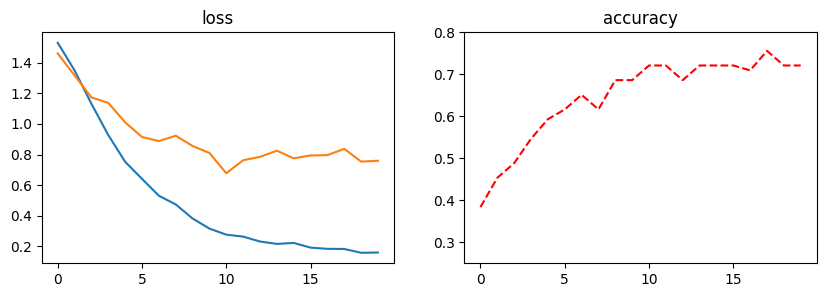

In [ ]:
# Print time spent
print('Time spent on training {} epochs: {:.0f}'.format(epochs, np.sum(time_spent)/60) + ' minutes')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(val_acc, color='red', linestyle='--')
plt.ylim(0.25,0.8)
plt.title('accuracy')

In [ ]:
torch.save(model.state_dict(), model_path)

### Perform on the test data

In [ ]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

Number of batches in the dataloader: 3


In [ ]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)

In [ ]:
# Set up list of test labels
ls_test_labels = df_test['Label'].values
rev_subs = { v:k for k,v in label_dict.items()}
ls_test_pred = [rev_subs.get(item,item)  for item in ls_test_pred]
# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.7558


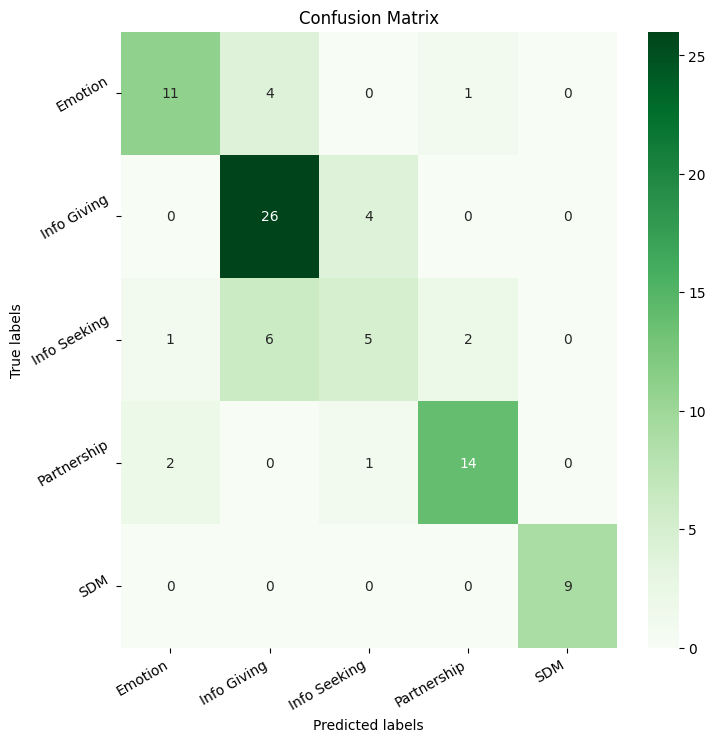

              precision    recall  f1-score   support

     Emotion       0.79      0.69      0.73        16
 Info Giving       0.72      0.87      0.79        30
Info Seeking       0.50      0.36      0.42        14
 Partnership       0.82      0.82      0.82        17
         SDM       1.00      1.00      1.00         9

    accuracy                           0.76        86
   macro avg       0.77      0.75      0.75        86
weighted avg       0.75      0.76      0.75        86



In [ ]:
# Confusion matrix
cm = confusion_matrix(ls_test_labels, ls_test_pred)
labels = ["Emotion","Info Giving","Info Seeking","Partnership","SDM"]

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

print(classification_report(list(ls_test_labels),list(ls_test_pred),labels=list(labels)))